# Survival Analysis
[### Additional Reading If Needed](https://www.ics.uci.edu/~dgillen/STAT255/Handouts/lecture10.pdf)

![My normal approach is useless here, too.](https://imgs.xkcd.com/comics/probability.png)

https://xkcd.com/881/

The aim of survival analysis is to analyze the effect of different risk factors and use them to predict the duration of time between one event ("birth") and another ("death").

# Customer Churn

Treselle Systems, a data consulting service, [analyzed customer churn data using logistic regression](http://www.treselle.com/blog/customer-churn-logistic-regression-with-r/). For simply modeling whether or not a customer left this can work, but if we want to model the actual tenure of a customer, survival analysis is more appropriate.

The "tenure" feature represents the duration that a given customer has been with them, and "churn" represents whether or not that customer left (i.e. the "event", from a survival analysis perspective). So, any situation where churn is "no" means that a customer is still active, and so from a survival analysis perspective the observation is censored (we have their tenure up to now, but we don't know their *true* duration until event).

I have  [used their data](https://github.com/treselle-systems/customer_churn_analysis) to fit a survival model, and answered  the following questions:

- What features best model customer churn?
- What would you characterize as the "warning signs" that a customer may discontinue service?
- What actions would you recommend to this business to try to improve their customer retention?

I've created a few plots and visualizations to support my findings, and in general wrote my  summary/results targeting an "interested layperson" (e.g. your hypothetical business manager) as the audience.

# Enjoy! :) 

In [117]:
# Loading the data to get you started
churn_data = pd.read_csv(
    'https://raw.githubusercontent.com/treselle-systems/'
    'customer_churn_analysis/master/WA_Fn-UseC_-Telco-Customer-Churn.csv')
churn_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [0]:
#churn_data.info()  # A lot of these are "object" - some may need to be fixed...

## Clean the Data

In [0]:
#@title
# Some columns we just don't need.
df = churn_data.drop(columns = 'customerID')

# The two numerical columns at the end should really be numerical
df['MonthlyCharges'] = pd.to_numeric(df['MonthlyCharges'])
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], 
                                       errors='coerce')

# There are 11 nulls in TotalCharges, which I'll replace with the mean
# value for that column
TotalCharges_mean = df['TotalCharges'].mean()
df['TotalCharges'].fillna(TotalCharges_mean, inplace=True)

# Lifelines requires numerical yes and no values.
#df = df.replace({'Yes':1, 'No':0})

##  Encode these Vars! 

In [120]:
#@title
from sklearn.preprocessing import LabelEncoder
# Split categorical and numeric cols
numerical_cols = ['tenure','MonthlyCharges','TotalCharges']
df_nums = df[numerical_cols]
df_cats = df.drop(columns=numerical_cols)

# Label Encode the Categorica Data

df_labeled = df_cats.apply(LabelEncoder().fit_transform)

# Join the numeric and labeled data. 
df_mint = df_nums.join(df_labeled)
#print(df_mint.shape)
df_mint.head()

,tenure,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,1,29.85,29.85,0,0,1,0,0,1,0,0,2,0,0,0,0,0,1,2,0
1,34,56.95,1889.50,1,0,0,0,1,0,0,2,0,2,0,0,0,1,0,3,0
2,2,53.85,108.15,1,0,0,0,1,0,0,2,2,0,0,0,0,0,1,3,1
3,45,42.30,1840.75,1,0,0,0,0,1,0,2,0,2,2,0,0,1,0,0,0
4,2,70.70,151.65,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,1


## Quick overview of the customer retention or "Lifetime" using `lifelines`

The redlines indicate customers who have discontinued the service.

The blue lines show the customers who were still customers and their lifespan as of the time of sampling. 

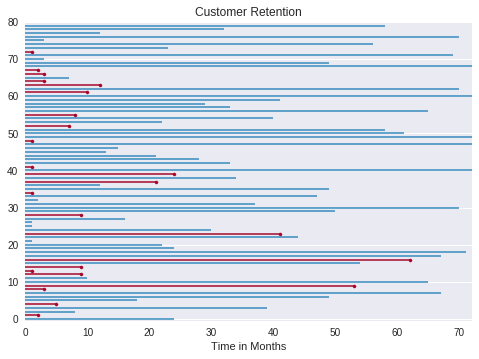

In [121]:
#@title
# Plot a random sample of customer retention. 
df_sort = df_mint.sort_values(['Churn', 'tenure'], ascending=[True, False])
df_sample = df_sort.sample(80)

time = df_sample.tenure.values
event = df_sample.Churn.values

ax = lifelines.plotting.plot_lifetimes(time, event_observed=event)
ax.set_xlim(0, 72)
ax.grid(axis='x')
ax.set_xlabel("Time in Months")
ax.set_title("Customer Retention");
plt.plot();

## Now for the KMF Survival Estimate Curve

This plot shows the normal loss of customers over the customer tenure starting at 100% and dropping over time. We will investigate the various factors that may be impacting this. 

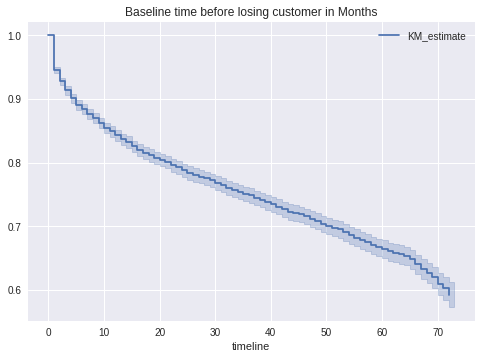

In [122]:
#@title
time = df_mint.tenure.values;
event = df_mint.Churn.values;

kmf = lifelines.KaplanMeierFitter();
kmf.fit(time, event_observed=event);
kmf.plot();
plt.title(f'Baseline time before losing customer in Months');

## Lets run a CPH Regression and make some recommendations! 

Wow! We got some great results with some very significant features! That's terriffic. 

Looks like Monthly Charges, Tech Support, Contract, and Payment Method might be interesting. 

In [123]:
#@title
# I use the Cox Proportional Hazards model for a survival regression
# The matrix has high collinearity, so the internet suggests 
# adding a penalizer term.  The rationale here is not entirely clear
cph = lifelines.CoxPHFitter(penalizer=0.01)
cph.fit(df_mint, 'tenure', event_col='Churn')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 observations, 5174 censored>
      duration col = 'tenure'
         event col = 'Churn'
number of subjects = 7043
  number of events = 1869
    log-likelihood = -12679.32
  time fit was run = 2019-01-25 06:39:36 UTC

---
                  coef  exp(coef)  se(coef)      z      p  log(p)  lower 0.95  upper 0.95     
MonthlyCharges    0.06       1.06      0.00  27.12 <0.005 -371.18        0.06        0.07  ***
TotalCharges     -0.00       1.00      0.00 -38.96 <0.005    -inf       -0.00       -0.00  ***
gender           -0.04       0.96      0.05  -0.91   0.36   -1.02       -0.13        0.05     
SeniorCitizen     0.04       1.04      0.06   0.69   0.49   -0.71       -0.07        0.15     
Partner          -0.18       0.84      0.05  -3.20 <0.005   -6.57       -0.28       -0.07    *
Dependents       -0.09       0.91      0.07  -1.33   0.18   -1.70       -0.23        0.04     
PhoneService     -0.21       0.81      0.12  -1.81   0.07   -2.66       -

## Lets look at the `Log(Hazard Ratio)` and see a bit more insight into which variables are significant. 

Wow, look at that contract residual plot! 

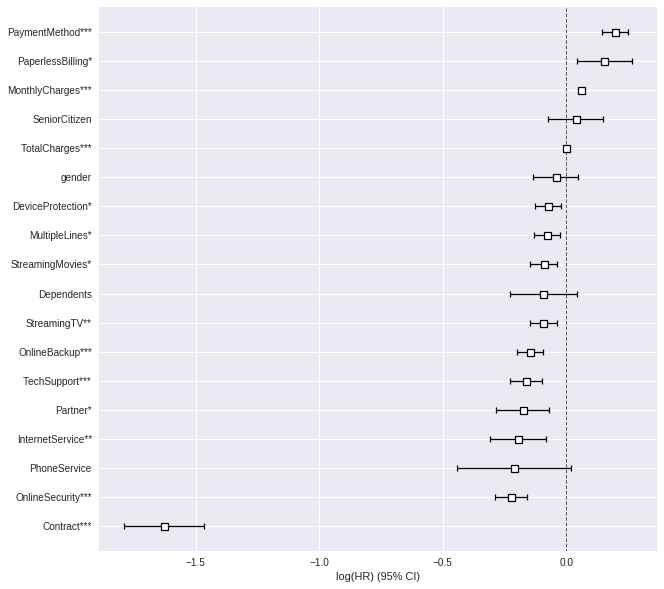

In [124]:
#@title
# I plot out the log(Hazard Ratio) for each variable, to show which variables
# are close to being significant.
fig, ax = plt.subplots(figsize=(10,10));
cph.plot(ax=ax);

## Lets look at a few of these features. I'll start with Contract Type

**Analysis:** Contract type has a very significant correlation with contract value. 

**Recommendation:** Do everything you can to move more customers onto contract. 

Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64
0    3875
2    1695
1    1473
Name: Contract, dtype: int64


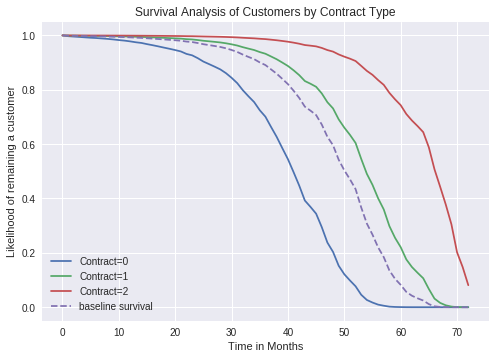

In [125]:
#@title
print(df.Contract.value_counts())
print(df_mint.Contract.value_counts())

cph.plot_covariate_groups('Contract', [0,1,2]);
plt.ylabel("Likelihood of remaining a customer")
plt.xlabel("Time in Months")
plt.title("Survival Analysis of Customers by Contract Type");

### Lets take a look at the Cumulative Hazard Curve for Contract as well



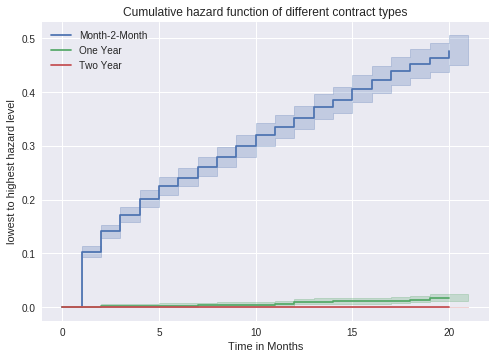

In [126]:
#@title
# Define the function
naf = lifelines.NelsonAalenFitter()

# A seperate plot for each label. 
m2m = df_mint['Contract'].values == 0
naf.fit(df_mint.tenure[m2m], event_observed=df_mint.Churn[m2m], label="Month-2-Month")
ax = naf.plot(loc=slice(0, 20))

oneyr = df_mint['Contract'].values == 1
naf.fit(df_mint.tenure[oneyr], event_observed=df_mint.Churn[oneyr], label="One Year")
naf.plot(ax=ax, loc=slice(0, 20))

twoyr = df_mint['Contract'].values == 2
naf.fit(df_mint.tenure[twoyr], event_observed=df_mint.Churn[twoyr], label="Two Year")
naf.plot(ax=ax, loc=slice(0, 20))

plt.title("Cumulative hazard function of different contract types");
plt.xlabel("Time in Months");
plt.ylabel("lowest to highest hazard level");

## I'm going to take a look at another feature: Payment Method

**Analysis:** These are interesting because the survivability analysis seem nominal, yet on further inspection the increased rate of loss of e-check users compounds quickly resulting in an NAF cumulative hazard function that shows a ton of seperation between payment methods. 

**Recommendation: ** I suggest moving more customers to automatic payment methods to prevent the loss of additional customers.  



Count of Customers by Type
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64
2    2365
3    1612
0    1544
1    1522
Name: PaymentMethod, dtype: int64


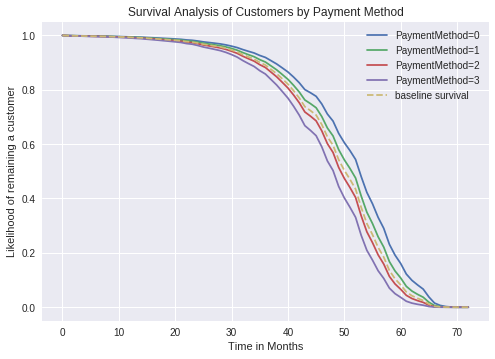

In [128]:
#@title
print("Count of Customers by Type")
print(df.PaymentMethod.value_counts())
print(df_mint.PaymentMethod.value_counts())

cph.plot_covariate_groups('PaymentMethod', [0,1,2,3]);
plt.ylabel("Likelihood of remaining a customer");
plt.xlabel("Time in Months");
plt.title("Survival Analysis of Customers by Payment Method");

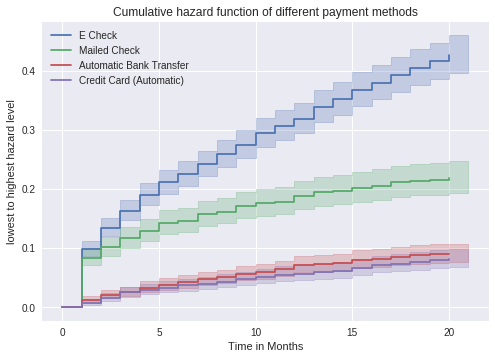

In [129]:
#@title
# Define the function
naf = lifelines.NelsonAalenFitter()

# A seperate plot for each label. 
echeck = df_mint['PaymentMethod'].values == 2
naf.fit(df_mint.tenure[echeck], event_observed=df_mint.Churn[echeck], label="E Check")
ax = naf.plot(loc=slice(0, 20))

mail = df_mint['PaymentMethod'].values == 3
naf.fit(df_mint.tenure[mail], event_observed=df_mint.Churn[mail], label="Mailed Check")
naf.plot(ax=ax, loc=slice(0, 20))

Bank = df_mint['PaymentMethod'].values == 0
naf.fit(df_mint.tenure[Bank], event_observed=df_mint.Churn[Bank], label="Automatic Bank Transfer")
naf.plot(ax=ax, loc=slice(0, 20))

CC = df_mint['PaymentMethod'].values == 1
naf.fit(df_mint.tenure[CC], event_observed=df_mint.Churn[CC], label="Credit Card (Automatic)")
naf.plot(ax=ax, loc=slice(0, 20))

plt.title("Cumulative hazard function of different payment methods");
plt.xlabel("Time in Months");
plt.ylabel("lowest to highest hazard level");

# Resources

Resources:
- [Wikipedia on Survival analysis](https://en.wikipedia.org/wiki/Survival_analysis)
- [Wikipedia on Survival functions](https://en.wikipedia.org/wiki/Survival_function)
- [Summary of survival analysis by a biostatistician](http://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_Survival/BS704_Survival_print.html)
- [Another medical statistics article on survival analysis](https://www.sciencedirect.com/science/article/pii/S1756231716300639)
- [Survival analysis using R lecture slides](http://www.stat.columbia.edu/~madigan/W2025/notes/survival.pdf)
